<a href="https://colab.research.google.com/github/dsobhani8/Generating-Gene-Expression-Responses-to-Environmental-Stress-Using-VAEs/blob/main/Final_ConditionalVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/dsobhani8/Generating-Gene-Expression-Responses-to-Environmental-Stress-Using-VAEs.git

fatal: destination path 'Generating-Gene-Expression-Responses-to-Environmental-Stress-Using-VAEs' already exists and is not an empty directory.


In [ ]:
!pip install umap-learn

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, LabelEncoder
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import zipfile
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import copy
import umap
from torch.utils.data import WeightedRandomSampler

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df_metadata = pd.read_csv('/content/Generating-Gene-Expression-Responses-to-Environmental-Stress-Using-VAEs/data/plants_metadata.csv')
df_metadata['run_accessions'] = df_metadata['run_accessions'].apply(lambda x: x.split(',')[0])

Conditions with more than 50 samples, such as Chironomus kiiensis and Globisporangium nunn—insects or pathogens that disrupt plants—were excluded, as our focus is on stressors likely to increase in relevance in the future, such as Cadmium, due to the growing prevalence of batteries.

In [ ]:
threshold=50
filtered_metadata = df_metadata[
    (df_metadata['Unified_Condition'].map(df_metadata['Unified_Condition'].value_counts()) >= threshold) &
    (df_metadata['Unified_Condition'] != "Nitrogen") &
    (df_metadata['Unified_Condition'] != "Chironomus kiiensis") &
    (df_metadata['Unified_Condition'] != "Globiosporangium nunn")
]


In [ ]:
if "Normal" in filtered_metadata['Unified_Condition'].unique():
    sampled_drought = filtered_metadata[filtered_metadata['Unified_Condition'] == "Normal"].sample(
        n=378, random_state=42
    )
filtered_metadata = pd.concat([
        filtered_metadata[filtered_metadata['Unified_Condition'] != "Normal"],
        sampled_drought
    ])

In [ ]:
filtered_metadata['Unified_Condition'].value_counts()

,count
Unified_Condition,
Normal,378
Cadmium,106
Flood,92
Salt,66
Cold,59
Drought,55


In [ ]:
df_metadata = filtered_metadata

In [ ]:
def load_and_preprocess_data(zip_file_path, df_metadata, variance_threshold=1e-10):
    # Load data
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        with zip_ref.open('combined_counts_matrix.txt') as file:
            df = pd.read_csv(file, sep='\t')

    df.set_index('Geneid', inplace=True)
    df = df.transpose()
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Accession'}, inplace=True)

    # print("Initial data:")
    # print(df.head())
    # print(df['Accession'])

    if 'run_accessions' not in df_metadata.columns:
        raise KeyError("df_metadata does not have an 'Accession' column.")

    valid_accessions = df_metadata['run_accessions'].unique()
    df = df[df['Accession'].isin(valid_accessions)]

    print(f"Data after filtering with metadata (rows retained): {df.shape[0]}")

    accession_values = df['Accession'].copy()

    df_numeric = df.drop(columns=['Accession']).apply(pd.to_numeric, errors='coerce')

    gene_variances = df_numeric.var()
    gene_stds = np.sqrt(gene_variances)  # Convert variances to std
    variable_genes = gene_stds[gene_stds > variance_threshold].index

    print(f"Original number of genes: {len(df_numeric.columns)}")
    print(f"Number of variable genes: {len(variable_genes)}")
    print(f"Removed {len(df_numeric.columns) - len(variable_genes)} constant genes")

    df_numeric = df_numeric[variable_genes]

    df_log = np.log1p(df_numeric)

    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df_log),
        columns=df_log.columns
    )

    df_scaled.insert(0, 'Accession', accession_values)

    X = df_scaled.drop(columns=['Accession']).values
    X_tensor = torch.tensor(X, dtype=torch.float32)

    return df_scaled, X_tensor, variable_genes


In [ ]:
zip_file_path = '/content/Generating-Gene-Expression-Responses-to-Environmental-Stress-Using-VAEs/data/combined_counts_matrix.txt.zip'
df_scaled, X_tensor, variable_genes = load_and_preprocess_data(zip_file_path, df_metadata)

Geneid  Accession  LOC4326813  LOC112163590  LOC4326455  LOC112163591  \
0       DRR145202           0             0           0             0   
1       DRR302331           0             0           0             0   
2       DRR254176           0             0           0             0   
3       DRR013398           4             0           0             4   
4       DRR002712           4             0           1            10   

Geneid  LOC4326456  LOC4326457  LOC4326458  LOC4326459  LOC4326460  ...  \
0                0           0           0           0           0  ...   
1                0           0           0           0           0  ...   
2                0           0           0           0           0  ...   
3                1           2           3          10           2  ...   
4                8           4          10           8           1  ...   

Geneid  OrsajCp107  OrsajCt160  OrsajCp108  OrsajCp109  OrsajCp110  \
0                0           0          

In [ ]:
class VAEDataLoader:
    def __init__(self, X, metadata_df=None, batch_size=32, train_ratio=0.8, random_seed=42, split_indices=None, min_test_samples_per_condition=5):
        self.batch_size = batch_size
        self.min_test_samples_per_condition = min_test_samples_per_condition

        if metadata_df is not None:
            if isinstance(X, torch.Tensor):
                X = X.numpy()

            data_df = pd.DataFrame(X)
            data_df['Accession'] = df_scaled['Accession']

            merged_df = data_df.merge(
                metadata_df,
                left_on='Accession',
                right_on='run_accessions',
                how='inner'
            )

            gene_cols = [col for col in data_df.columns if col != 'Accession']
            self.X = torch.tensor(merged_df[gene_cols].values, dtype=torch.float32)
            self.metadata_df = merged_df.reset_index(drop=True)
            condition_encodings = pd.get_dummies(self.metadata_df['Unified_Condition'])
            self.conditions = torch.tensor(condition_encodings.values, dtype=torch.float32)
        else:
            if not isinstance(X, torch.Tensor):
                self.X = torch.tensor(X, dtype=torch.float32)
            else:
                self.X = X
            self.conditions = None
            self.metadata_df = None

        self.create_splits(train_ratio, random_seed, split_indices)

    def create_splits(self, train_ratio, random_seed, split_indices=None):
        if split_indices is not None:
            self.train_indices, self.test_indices = split_indices
            return

        if self.metadata_df is None or self.conditions is None:
            num_samples = len(self.X)
            indices = np.arange(num_samples)
            np.random.seed(random_seed)
            np.random.shuffle(indices)
            split_idx = int(train_ratio * num_samples)
            self.train_indices = indices[:split_idx]
            self.test_indices = indices[split_idx:]
            return

        np.random.seed(random_seed)

        condition_groups = self.metadata_df.groupby('Unified_Condition').apply(lambda df: df.index.values).to_dict()

        forced_test_indices = []
        for condition, idx_array in condition_groups.items():
            if len(idx_array) < self.min_test_samples_per_condition:
                raise ValueError(f"Condition '{condition}' has only {len(idx_array)} samples, "
                                 f"which is less than the required minimum of {self.min_test_samples_per_condition} for the test set.")

            chosen_test = np.random.choice(idx_array, size=self.min_test_samples_per_condition, replace=False)
            forced_test_indices.extend(chosen_test)

        forced_test_indices = np.array(forced_test_indices)

        all_indices = np.arange(len(self.X))
        remaining_indices = np.setdiff1d(all_indices, forced_test_indices)

        np.random.shuffle(remaining_indices)

        desired_test_size = int((1 - train_ratio) * len(self.X))
        additional_test_needed = max(0, desired_test_size - len(forced_test_indices))

        if additional_test_needed > 0:
            additional_test_indices = remaining_indices[:additional_test_needed]
            self.test_indices = np.concatenate([forced_test_indices, additional_test_indices])
            self.train_indices = remaining_indices[additional_test_needed:]
        else:
            self.test_indices = forced_test_indices
            self.train_indices = remaining_indices

    def get_loaders(self):
        if self.conditions is not None:
            train_dataset = TensorDataset(
                self.X[self.train_indices],
                self.conditions[self.train_indices]
            )
            test_dataset = TensorDataset(
                self.X[self.test_indices],
                self.conditions[self.test_indices]
            )
        else:
            train_dataset = TensorDataset(self.X[self.train_indices])
            test_dataset = TensorDataset(self.X[self.test_indices])

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size)

        return train_loader, test_loader

    def get_split_indices(self):
        return self.train_indices, self.test_indices

    def get_condition_dim(self):
        return self.conditions.shape[1] if self.conditions is not None else None


In [ ]:
class FlexibleVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10, hidden_dims=[128], condition_dim=None):
        super(FlexibleVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim
        self.is_conditional = condition_dim is not None

        # Encoder
        encoder_input_dim = input_dim + (condition_dim if self.is_conditional else 0)
        self.encoder = nn.Sequential(
            nn.Linear(encoder_input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.fc_mean = nn.Linear(hidden_dims[0], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[0], latent_dim)

        # Decoder
        decoder_input_dim = latent_dim + (condition_dim if self.is_conditional else 0)
        self.decoder = nn.Sequential(
            nn.Linear(decoder_input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dims[0], input_dim)
        )

    def encode(self, x, c=None):
        if self.is_conditional and c is not None:
            x = torch.cat([x, c], dim=1)
        h = self.encoder(x)
        return self.fc_mean(h), self.fc_logvar(h)

    def decode(self, z, c=None):
        if self.is_conditional and c is not None:
            z = torch.cat([z, c], dim=1)
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * torch.clamp(logvar, min=-10, max=10))
        eps = torch.randn_like(std)
        return mu + eps * std

    def kl_loss(self, mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()

    def forward(self, x, c=None):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

def create_metadata_encodings(df):
    """Create one-hot encodings for unified conditions"""
    condition_encodings = pd.get_dummies(df['Unified_Condition'])
    return condition_encodings, {'all_conditions': condition_encodings}


def prepare_data(X, metadata_df=None):
    """Prepare data for VAE training (conditional or non-conditional)"""
    X_tensor = torch.tensor(X, dtype=torch.float32)

    if metadata_df is not None:
        print("\nShape of X:", X.shape)
        metadata_encoded, encoding_dict = create_metadata_encodings(metadata_df)
        condition_tensor = torch.tensor(metadata_encoded.values, dtype=torch.float32)
        print("\nShape of condition tensor:", condition_tensor.shape)

        # Verify matching dimensions
        print("\nNumber of samples match?", X.shape[0] == condition_tensor.shape[0])

        dataset = TensorDataset(X_tensor, condition_tensor)
        return dataset, metadata_encoded, encoding_dict
    else:
        dataset = TensorDataset(X_tensor)
        return dataset, None, None

def calculate_condition_weights(metadata_encoded, min_samples=5):
    """Calculate weights for conditions with minimum number of samples"""
    condition_counts = metadata_encoded.sum(axis=0).values

    # Filter conditions with enough samples
    valid_conditions = condition_counts >= min_samples
    filtered_counts = condition_counts[valid_conditions]

    if len(filtered_counts) == 0:
        print("No conditions meet the minimum sample requirement!")
        return None

    total_samples = filtered_counts.sum()

    # Calculate weights using numpy first
    weights = np.zeros(len(condition_counts))
    weights[valid_conditions] = total_samples / (filtered_counts * len(filtered_counts))

    weights = torch.tensor(weights, dtype=torch.float32)

    weights = weights / weights.sum()

    print("\nCondition weights (conditions with >= {} samples):".format(min_samples))
    for condition, count, weight in zip(metadata_encoded.columns, condition_counts, weights):
        if count >= min_samples:
            print(f"{condition} (n={int(count)}): {weight:.4f}")

    return weights

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """Compute VAE loss"""
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss

def train_vae(model, data_loader, num_epochs=10, device="cuda",
              patience=5, min_delta=0.001):
    """Train VAE with early stopping (no weights)"""
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model.train()

    best_loss = float('inf')
    counter = 0
    best_model = None

    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0

        for batch in data_loader:
            if model.is_conditional:
                x, c = batch
                c = c.to(device, torch.float32)
            else:
                x = batch[0]
                c = None

            x = x.to(device, torch.float32)
            optimizer.zero_grad()

            recon_x, mu, logvar = model(x, c)
            loss = vae_loss(recon_x, x, mu, logvar)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / num_batches
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

        if avg_loss < best_loss - min_delta:
            best_loss = avg_loss
            counter = 0
            best_model = copy.deepcopy(model.state_dict())
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs")
                model.load_state_dict(best_model)
                return model

    if best_model is not None:
        model.load_state_dict(best_model)
    return model


def run_vae_training(df_scaled, df_metadata=None, batch_size=16, num_epochs=10, latent_dim=10,
                     patience=5, min_delta=0.001, train_loader=None, test_loader=None,
                     split_indices=None, is_conditional=True):
    """Run training for VAE (no weights)"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X = df_scaled.drop('Accession', axis=1).values

    if train_loader is None or test_loader is None:
        if df_metadata is not None:
            merged_df = df_scaled.merge(
                df_metadata,
                left_on='Accession',
                right_on='run_accessions',
                how='inner'
            )

            gene_cols = [col for col in df_scaled.columns if col != 'Accession']
            X = merged_df[gene_cols].values
            metadata_df = merged_df[['Unified_Condition']]
            _, metadata_encoded, _ = prepare_data(X, metadata_df)
        else:
            metadata_df = None

        data_loader_class = VAEDataLoader(X, metadata_df, batch_size=batch_size, split_indices=split_indices)
        train_loader, test_loader = data_loader_class.get_loaders()
        condition_dim = data_loader_class.get_condition_dim() if is_conditional else None
    else:
        condition_dim = train_loader.dataset[0][1].shape[0] if is_conditional else None

    model = FlexibleVAE(input_dim=X.shape[1],
                        latent_dim=latent_dim,
                        condition_dim=condition_dim).to(device)

    train_vae(model, train_loader, num_epochs=num_epochs, patience=patience,
              min_delta=min_delta, device=device)

    return model, train_loader, test_loader

In [ ]:
def calculate_mse(model, data_loader, device="cuda"):
    """Calculate the Mean Squared Error (MSE) of the VAE reconstructions."""
    model.eval()
    mse_values = []

    with torch.no_grad():
        for batch in data_loader:
            if model.is_conditional:
                x, c = batch
                c = c.to(device, torch.float32)
            else:
                x = batch[0]
                c = None

            x = x.to(device, torch.float32)

            recon_x, _, _ = model(x, c)

            batch_mse = mean_squared_error(x.cpu().numpy(), recon_x.cpu().numpy())
            mse_values.append(batch_mse)

    avg_mse = sum(mse_values) / len(mse_values)
    print(f"Average MSE: {avg_mse:.4f}")
    return avg_mse

def evaluate_vae(model, test_loader, device="cuda"):
    """Evaluate VAE performance on test data using MSE."""
    average_mse = calculate_mse(model, test_loader, device=device)
    print(f"Test MSE: {average_mse:.4f}")
    return average_mse

In [ ]:
data_loader_class = VAEDataLoader(X_tensor, df_metadata, batch_size=64, random_seed=42)
train_loader, test_loader = data_loader_class.get_loaders()
train_indices, test_indices = data_loader_class.get_split_indices()


<ipython-input-12-614f31a35d83>:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  condition_groups = self.metadata_df.groupby('Unified_Condition').apply(lambda df: df.index.values).to_dict()


In [ ]:
# For VAE
vae_model, _, _ = run_vae_training(
    df_scaled,
    df_metadata=df_metadata,
    num_epochs=150,
    train_loader=train_loader,
    test_loader=test_loader,
    is_conditional=False
)

# For CVAE
cvae_model, _, _ = run_vae_training(
    df_scaled,
    df_metadata=df_metadata,
    num_epochs=150,
    train_loader=train_loader,
    test_loader=test_loader,
    is_conditional=True
)

Epoch [1/150], Average Loss: 2761642.1250
Epoch [2/150], Average Loss: 2744871.2500
Epoch [3/150], Average Loss: 2722195.5625
Epoch [4/150], Average Loss: 2695502.7500
Epoch [5/150], Average Loss: 2684056.6250
Epoch [6/150], Average Loss: 2692125.6250
Epoch [7/150], Average Loss: 2658266.1250
Epoch [8/150], Average Loss: 2652824.5000
Epoch [9/150], Average Loss: 2642003.0625
Epoch [10/150], Average Loss: 2625425.9375
Epoch [11/150], Average Loss: 2610112.6875
Epoch [12/150], Average Loss: 2595851.2500
Epoch [13/150], Average Loss: 2584424.6250
Epoch [14/150], Average Loss: 2572509.8125
Epoch [15/150], Average Loss: 2550232.8750
Epoch [16/150], Average Loss: 2533836.5000
Epoch [17/150], Average Loss: 2523857.0625
Epoch [18/150], Average Loss: 2515415.1250
Epoch [19/150], Average Loss: 2490156.5000
Epoch [20/150], Average Loss: 2482583.0625
Epoch [21/150], Average Loss: 2480303.3750
Epoch [22/150], Average Loss: 2453398.7500
Epoch [23/150], Average Loss: 2438642.4375
Epoch [24/150], Aver

In [ ]:
test_mse_cvae = evaluate_vae(cvae_model, test_loader)
test_mse_vae = evaluate_vae(vae_model, test_loader)

Average MSE: 0.3115
Test MSE: 0.3115
Average MSE: 0.3664
Test MSE: 0.3664


In [ ]:
def estimate_log_likelihood(model, data_loader, num_samples=100, device="cuda"):
    """
    Estimate the marginal log-likelihood of data under a (C)VAE model using importance sampling.
    """
    model.eval()
    total_log_likelihood = 0.0
    num_data_points = 0

    with torch.no_grad():
        for batch in data_loader:
            if model.is_conditional:
                x, c = batch
                c = c.to(device, dtype=torch.float32)
            else:
                x = batch[0]
                c = None

            x = x.to(device, dtype=torch.float32)
            batch_size = x.size(0)


            importance_weights = torch.zeros(batch_size, num_samples, device=device)

            for i in range(num_samples):
                mu, logvar = model.encode(x, c)
                std = torch.exp(0.5 * logvar)

                z = mu + std * torch.randn_like(std)
                recon_x = model.decode(z, c)

                log_p_x_z = -0.5 * F.mse_loss(recon_x, x, reduction='none').sum(dim=1)


                log_p_z = -0.5 * torch.sum(z ** 2, dim=1)

                log_q_z_x = -0.5 * torch.sum(logvar + (z - mu) ** 2 / torch.exp(logvar), dim=1)

                importance_weights[:, i] = (log_p_x_z + log_p_z - log_q_z_x)

            max_weights, _ = torch.max(importance_weights, dim=1, keepdim=True)
            log_likelihood_per_datapoint = (max_weights.squeeze(1)
                                            + torch.log(torch.mean(
                                                torch.exp(importance_weights - max_weights), dim=1
                                            )))

            total_log_likelihood += log_likelihood_per_datapoint.sum().item()
            num_data_points += batch_size

    average_log_likelihood = total_log_likelihood / num_data_points
    return average_log_likelihood


In [ ]:
# For conditional VAE
cond_ll = estimate_log_likelihood(cvae_model, test_loader, num_samples=100)
print(f"Conditional VAE log likelihood: {cond_ll:.4f}")

# For non-conditional VAE
noncond_ll = estimate_log_likelihood(vae_model, test_loader, num_samples=100)
print(f"Non-conditional VAE log likelihood: {noncond_ll:.4f}")

Conditional VAE log likelihood: -5172.2112
Non-conditional VAE log likelihood: -5818.7903


In [ ]:
def visualize_latent_space(model, data_loader, metadata_df, model_name="model", device="cuda"):
    z_list = []
    conditions = []

    unique_conditions = metadata_df['Unified_Condition'].unique()
    condition_mapping = {i: cond for i, cond in enumerate(unique_conditions)}

    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            x, c = batch
            x, c = x.to(device), c.to(device)

            mu, _ = model.encode(x, c)
            z_list.append(mu.cpu().numpy())

            batch_indices = torch.argmax(c, dim=1).cpu().numpy()
            batch_conditions = [condition_mapping[idx] for idx in batch_indices]
            conditions.extend(batch_conditions)

    Z = np.vstack(z_list)
    conditions = np.array(conditions)

    scaler = StandardScaler()
    Z_normalized = scaler.fit_transform(Z)

    Z_embedded = umap.UMAP(random_state=42).fit_transform(Z_normalized)

    unique_conditions = np.unique(conditions)
    cmap = plt.cm.get_cmap('tab20', len(unique_conditions))
    color_dict = {cond: cmap(i) for i, cond in enumerate(unique_conditions)}

    plt.figure(figsize=(12, 8))

    for cond in unique_conditions:
        mask = conditions == cond
        plt.scatter(Z_embedded[mask, 0], Z_embedded[mask, 1],
                    color=color_dict[cond], label=cond, alpha=0.7)

    plt.title(f'UMAP Visualization of Latent Space ({model_name})')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    plt.xticks([])
    plt.yticks([])

    filename = f"{model_name}_umap.pdf"
    plt.savefig(filename)
    print(f"UMAP plot saved to {filename}")

    plt.show()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-21-e71b2c46368d>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_conditions))


UMAP plot saved to CVAE_umap.pdf


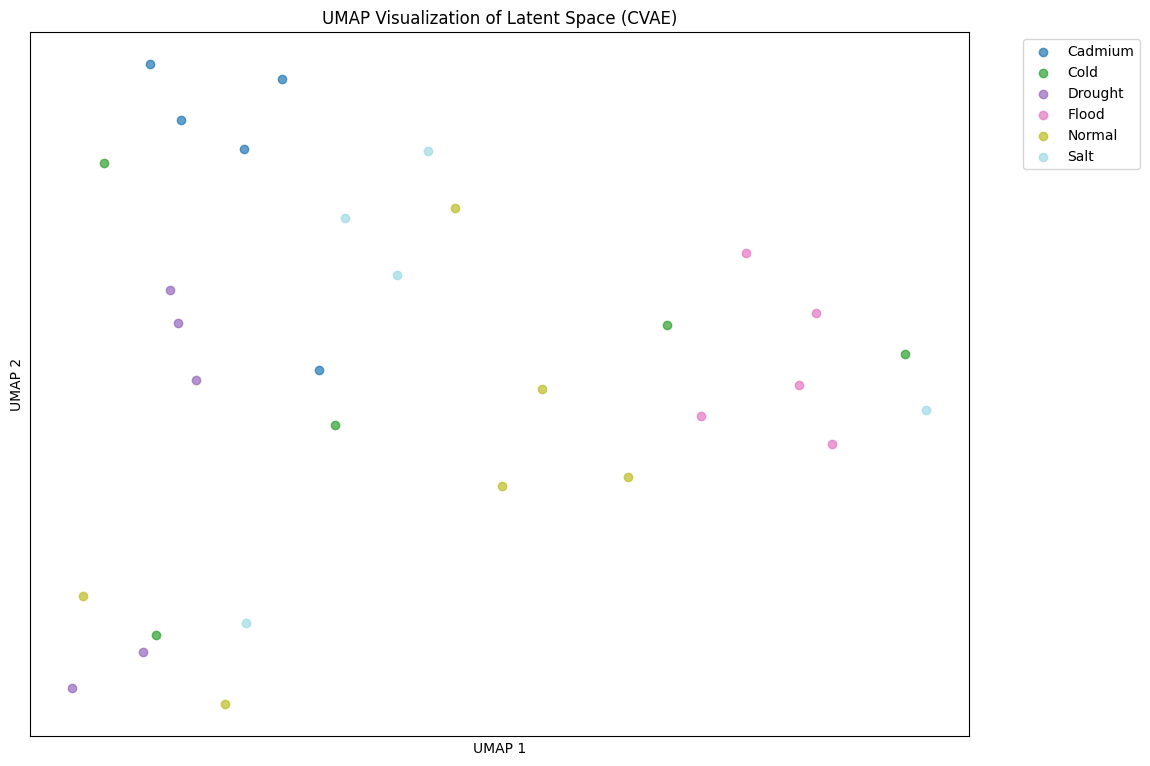

In [ ]:
visualize_latent_space(cvae_model, test_loader, df_metadata[['Unified_Condition']], model_name='CVAE')

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-21-e71b2c46368d>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_conditions))


UMAP plot saved to vae_umap.pdf


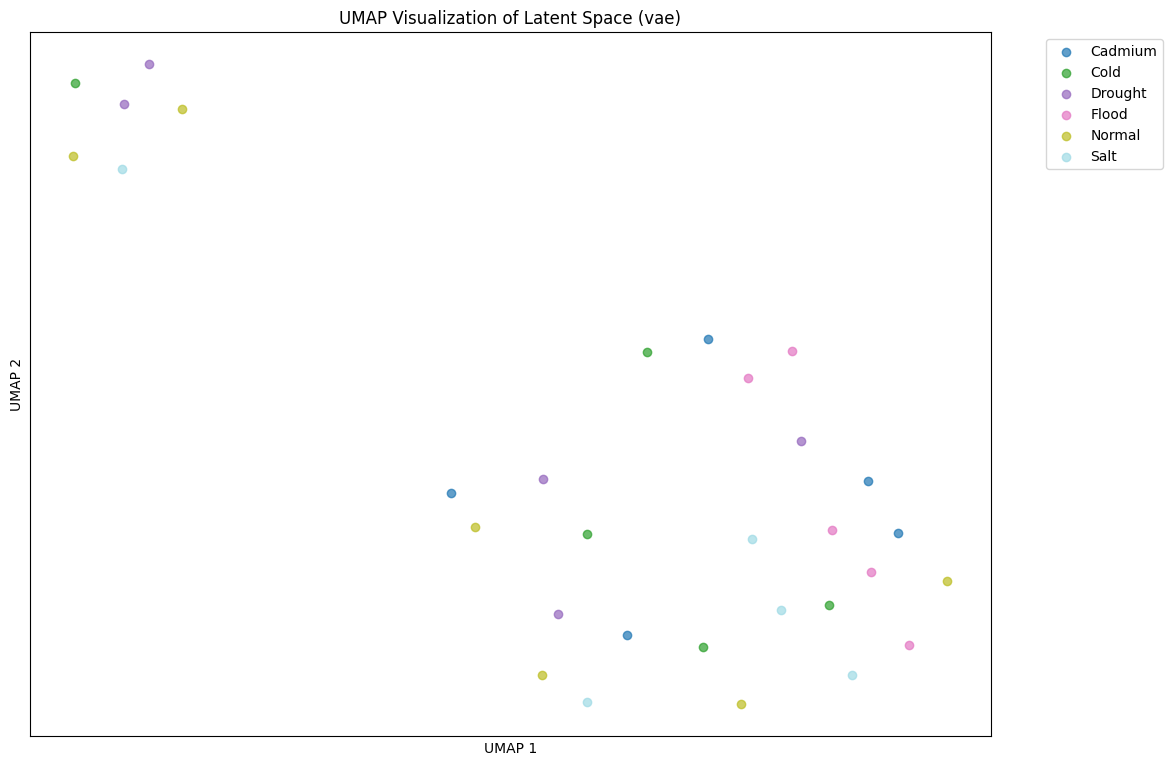

In [ ]:
visualize_latent_space(vae_model, test_loader, df_metadata[['Unified_Condition']],model_name='vae')

In [ ]:
def analyze_vae_by_condition(model, data_loader, metadata_df, device="cuda", top_n=5, is_conditional=False):
    """
    Analyze VAE performance for each condition with optional conditional handling.

    Parameters:
        model: The VAE or CVAE model to analyze.
        data_loader: DataLoader containing test data.
        metadata_df: DataFrame with metadata, including 'Unified_Condition'.
        device: Device to run on ('cuda' or 'cpu').
        top_n: Number of top conditions to display.
        is_conditional: Whether the model is conditional (e.g., CVAE).

    Returns:
        metrics_df: DataFrame with performance metrics by condition.
    """
    model.eval()
    condition_names = pd.get_dummies(metadata_df['Unified_Condition']).columns.tolist()
    condition_data = {cond: {'actual': [], 'predicted': []} for cond in condition_names}

    with torch.no_grad():
        for batch in data_loader:
            if is_conditional:
                x, c = batch
                x, c = x.to(device, torch.float32), c.to(device, torch.float32)
                recon_x, _, _ = model(x, c)
            else:
                x, c = batch
                x = x.to(device, torch.float32)
                recon_x, _, _ = model(x)

            x_np = x.cpu().numpy()
            recon_x_np = recon_x.cpu().numpy()
            c_np = c.cpu().numpy()

            for i in range(len(x)):
                condition_idx = np.argmax(c_np[i])
                condition = condition_names[condition_idx]
                condition_data[condition]['actual'].append(x_np[i])
                condition_data[condition]['predicted'].append(recon_x_np[i])

    condition_metrics = {}
    for condition in condition_names:
        if len(condition_data[condition]['actual']) > 0:
            actual = np.vstack(condition_data[condition]['actual'])  # shape: (n_samples, n_genes)
            predicted = np.vstack(condition_data[condition]['predicted'])  # shape: (n_samples, n_genes)

            mse = np.mean((actual - predicted) ** 2)
            pearson_corrs = []
            spearman_corrs = []
            n_constant_samples = 0
            n_valid_samples = 0

            # Compute correlations on a per-sample basis across genes
            for s in range(actual.shape[0]):
                actual_sample = actual[s, :]
                pred_sample = predicted[s, :]

                # Check variation within this sample
                if np.std(actual_sample) > 0 and np.std(pred_sample) > 0:
                    p_corr = pearsonr(actual_sample, pred_sample)[0]
                    s_corr = spearmanr(actual_sample, pred_sample)[0]

                    if not np.isnan(p_corr) and not np.isnan(s_corr):
                        pearson_corrs.append(p_corr)
                        spearman_corrs.append(s_corr)
                        n_valid_samples += 1
                else:
                    n_constant_samples += 1

            condition_metrics[condition] = {
                'n_samples': actual.shape[0],
                'n_genes': actual.shape[1],
                'n_valid_samples': n_valid_samples,
                'n_constant_samples': n_constant_samples,
                'mse': mse,
                'mean_pearson': np.mean(pearson_corrs) if pearson_corrs else np.nan,
                'mean_spearman': np.mean(spearman_corrs) if spearman_corrs else np.nan,
                'pct_valid_samples': (n_valid_samples / actual.shape[0]) * 100 if actual.shape[0] > 0 else 0
            }

    metrics_df = pd.DataFrame.from_dict(condition_metrics, orient='index')
    metrics_df = metrics_df.sort_values('n_samples', ascending=False)

    top_conditions = metrics_df.head(top_n)

    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    axes[0].bar(range(len(top_conditions)), top_conditions['mse'])
    axes[0].set_xticks(range(len(top_conditions)))
    axes[0].set_xticklabels(top_conditions.index, rotation=45, ha='right')
    axes[0].set_title('MSE by Condition')
    axes[0].set_ylabel('MSE')

    width = 0.35
    x = np.arange(len(top_conditions))
    valid_mask = ~top_conditions['mean_pearson'].isna()

    if valid_mask.any():
        axes[1].bar(x[valid_mask] - width/2, top_conditions[valid_mask]['mean_pearson'], width, label='Pearson')
        axes[1].bar(x[valid_mask] + width/2, top_conditions[valid_mask]['mean_spearman'], width, label='Spearman')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(top_conditions.index, rotation=45, ha='right')
        axes[1].set_title('Mean Correlations by Condition (Within Sample)')
        axes[1].set_ylabel('Correlation')
        axes[1].legend()

    plt.tight_layout()
    plt.show()

    print("\nPerformance metrics:")
    print(top_conditions[['mse', 'mean_pearson', 'mean_spearman']].round(4))

    return metrics_df


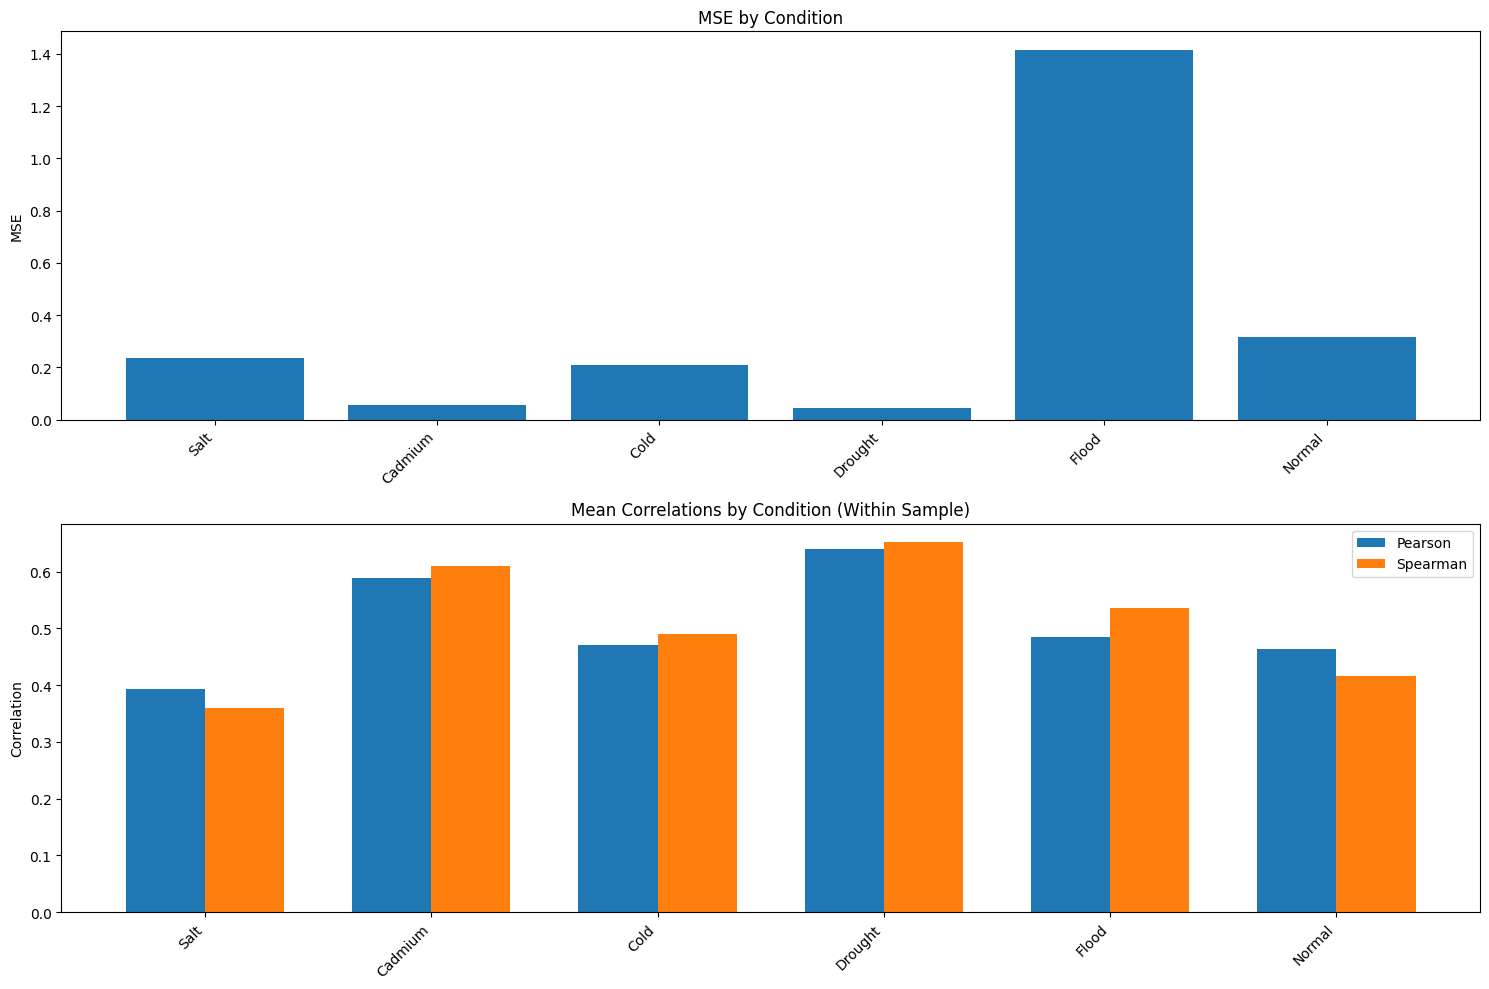


Performance metrics:
            mse  mean_pearson  mean_spearman
Salt     0.2374        0.3936         0.3599
Cadmium  0.0552        0.5879         0.6094
Cold     0.2107        0.4715         0.4902
Drought  0.0446        0.6405         0.6516
Flood    1.4156        0.4850         0.5357
Normal   0.3164        0.4635         0.4159


In [ ]:
metrics_unconditional = analyze_vae_by_condition(
    model=vae_model,
    data_loader=test_loader,
    metadata_df=df_metadata[['Unified_Condition']],
    device="cuda",
    top_n=8,
    is_conditional=False
)


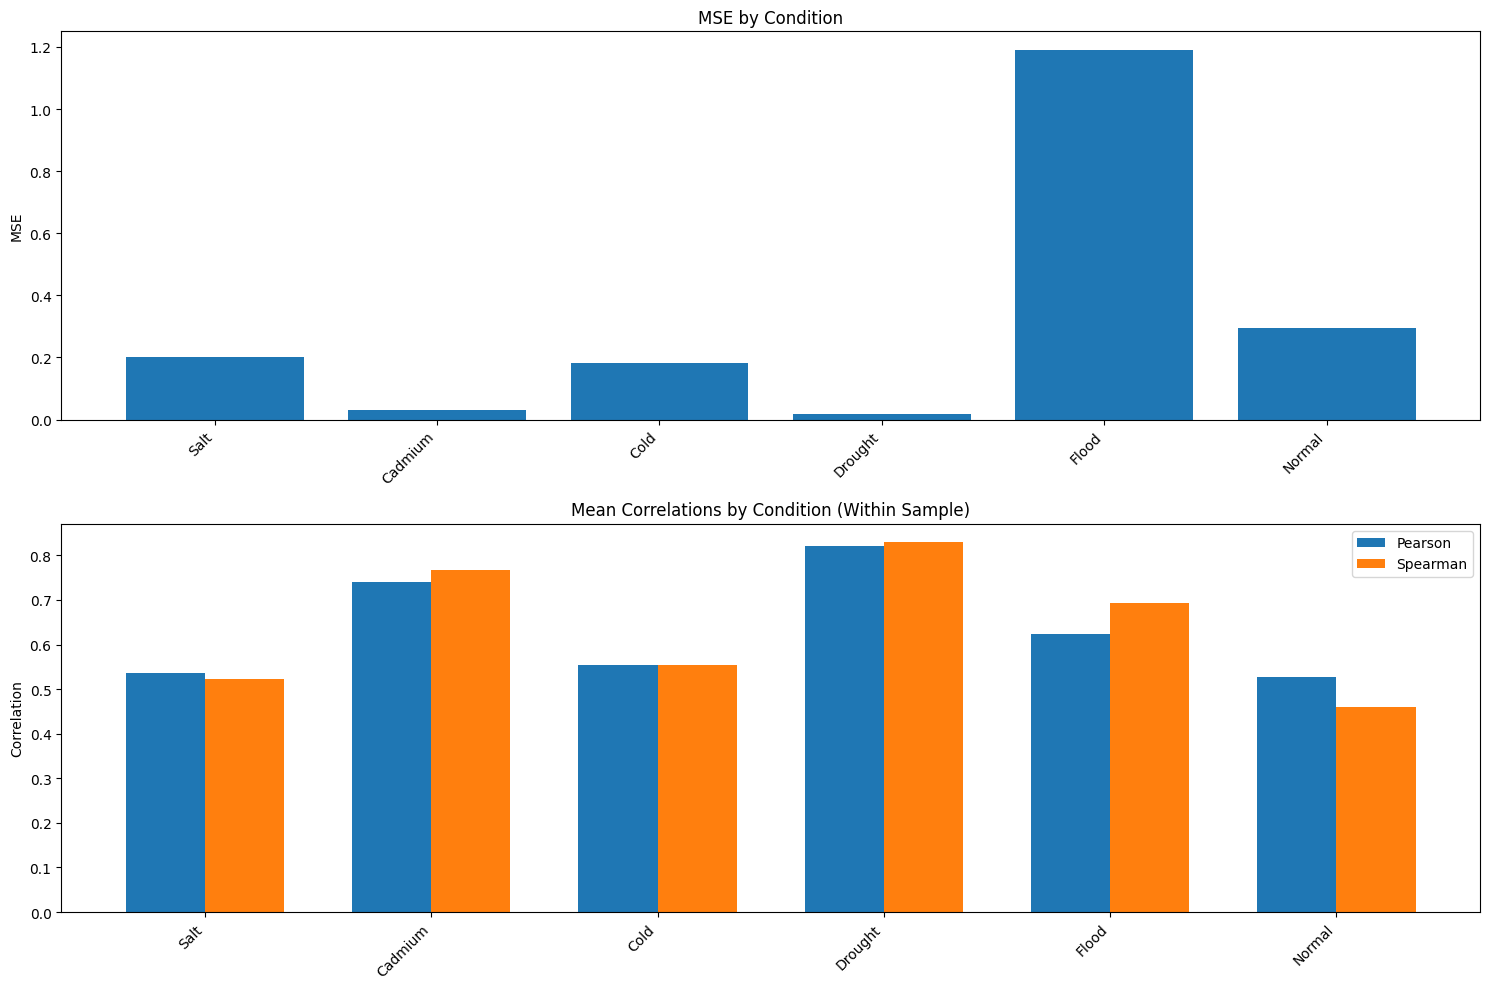


Performance metrics:
            mse  mean_pearson  mean_spearman
Salt     0.2007        0.5351         0.5228
Cadmium  0.0313        0.7406         0.7681
Cold     0.1833        0.5532         0.5535
Drought  0.0188        0.8213         0.8291
Flood    1.1907        0.6238         0.6934
Normal   0.2950        0.5280         0.4590


In [ ]:
metrics_conditional = analyze_vae_by_condition(
    model=cvae_model,
    data_loader=test_loader,
    metadata_df=df_metadata[['Unified_Condition']],
    device="cuda",
    top_n=8,
    is_conditional=True
)
